In [355]:
# %load main.py
import networkx as nx
import random as rand
from utils import *
import math

class Person(object):
    #static variable
    population = 0
    def __init__(self,id_num=None,ideo=None, capacity=4.0):
        self.id_num = id_num if id_num!=None else Person.population
        Person.population += 1
        self.ideo = ideo if ideo!=None else rand.uniform(-1,1)
        #2*randint(0,1)-1
        #rand.uniform(-1,1)
        self.capacity = capacity
    def __eq__(self,other):
        if not (isinstance(other,Person)):
            return False
        return self.id_num==other.id_num
    def __hash__(self):
        return hash(self.id_num)

def clamp(x,lo=0,hi=1):
    return lo if x<lo else \
           hi if x>hi else x

def new_ideo(graph,node,wt=0.9,noise=0.05):
    s = sum_friend_weights(graph,node)
    return clamp(wt*node.ideo 
        + ((1-wt)*sum([nbr.ideo*graph.adj[node][nbr]['weight'] for nbr in graph.adj[node]])/s
                 if s!=0 else (1-wt)*node.ideo)
        + rand.gauss(0,noise),-1,1)

def update_ideos(graph, wt=0.9,noise=0.05):
    #ideos = [new_ideo(graph,node,wt,noise) for node in graph.nodes()]
    ideos = [new_ideo(graph,node,.8+.2*abs(node.ideo),noise) for node in graph.nodes()]
    for (node, ideo) in zip(graph.nodes(),ideos):
        node.ideo = ideo

def update_friendships(graph, node, sigma=0.05):
    dels = []
    for nbr in graph.adj[node]:
        graph.adj[node][nbr]['weight']= clamp(graph.adj[node][nbr]['weight'] - .01*(abs(node.ideo-nbr.ideo)-1)
                                              + rand.gauss(0,sigma))
        if graph.adj[node][nbr]['weight']==0:
            dels +=[nbr]
    for nbr in dels:
        graph.remove_edge(node,nbr)

def get_potential_friend(graph, node, p=0.1):
    if rand.random()<p:
        friend = sample(list(graph.nodes()))
    else:
        f = step_rand_walk(graph,node)
        if f==None:
            return None
        friend = step_rand_walk(graph,f)
        if friend==None:
            return None #this shouldn't happen
    if not (friend == None or node == friend or friend in graph.adj[node]):
        #graph.add_edge(node, friend, weight=0.5)
        return friend
    return None

def maybe_make_friend(graph, node, p=0.1, acc_fn=lambda me, you: math.exp(abs(me.ideo-you.ideo))
                     ):
    if rand.random()<=(node.capacity - sum_friend_weights(graph,node))/node.capacity:
        friend = get_potential_friend(graph,node,p)
        if friend == None:
            return None
        if rand.random()<=acc_fn(node, friend):
            graph.add_edge(node, friend, weight=0.5)
            return friend
    return None

def sum_friend_weights(graph,node):
    return sum([graph.adj[node][neighbor]['weight'] for neighbor in graph.adj[node]])

def step_rand_walk(graph, node):
    #print(node)
    sum_weights = sum_friend_weights(graph, node)
    if sum_weights==0:
        return None
    li = [(neighbor, graph.adj[node][neighbor]['weight']/sum_weights) for neighbor in graph.adj[node]]
    #print(li)
    x = sample_wp(li)
    #print("hi",x)
    return x

def sample(li):
    if len(li)==0:
        return None
    return li[rand.randint(0,len(li)-1)]

def loop_step(graph,sigma=0.05,p=0.1,
              acc_fn=lambda me, you: math.exp(-abs(me.ideo-you.ideo)), influence=False,
              wt=0.9,noise=0):
    for node in graph.nodes():
        if influence:
            update_ideos(graph, wt, noise)
        update_friendships(graph,node,sigma)
        maybe_make_friend(graph,node,p,acc_fn)

def init_graph(pop):
    nodes = [Person(capacity=rand.randint(2,5)) for i in range(pop)]
    G=nx.Graph()
    G.add_nodes_from(nodes)
    return G

def test():
    G = nx.Graph()
    G.add_nodes_from([1,2,3,4,5,6])
    G.add_edges_from([(1,2,{'weight':1.0}),
                      (1,3,{'weight':2.0}),
                      (2,4,{'weight':10.0}),
                      (3,5,{'weight':10.0}),
                      (3,6,{'weight':20.0})])
    #print(G.adj)
    for t in range(15):
        print(step_rand_walk(G,step_rand_walk(G,1)))
    nx.draw(G)
    p=Person()
    q=Person()
    print(Person.population)

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.clf()

<Figure size 432x288 with 0 Axes>

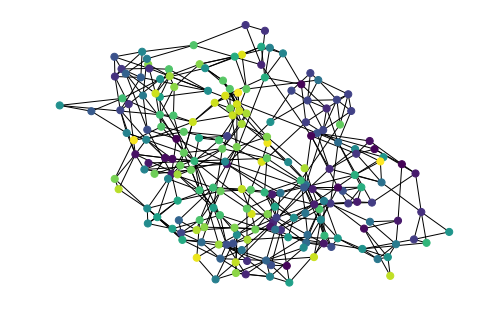

In [361]:
G=init_graph(200)
colors = [person.ideo for person in G.nodes()]
#print(G.nodes())
for t in range(500):
    loop_step(G, sigma=0.1,p=0.1, acc_fn=lambda me, you: .3#math.exp(-abs(me.ideo-you.ideo))
             )
plt.clf()
nx.draw(G, node_size=50, node_color = colors, cmap=plt.cm.viridis, vmin=-1, vmax=1)
#nx.draw(G)

Text(0,0.5,'Average Ideology of Friends')

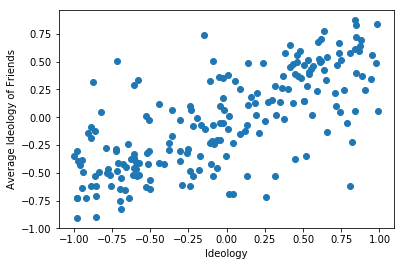

In [362]:
xs = [person.ideo for person in G.nodes]
ys = [sum([friend.ideo * G.adj[person][friend]['weight'] for friend in G.adj[person]])/sum([G.adj[person][friend]['weight'] for friend in G.adj[person]]) for person in G.nodes]
plt.plot(xs, ys, 'o')
plt.xlabel('Ideology')
plt.ylabel('Average Ideology of Friends')

In [363]:
from scipy.stats.stats import pearsonr
pearsonr(xs,ys)

(0.7213728545463486, 2.003823216114259e-33)

In [276]:
xs

[0.28169833538269007,
 0.2816983353826893,
 0.28169833538269007,
 0.2816983353826902,
 0.28169833538269023,
 0.281698335382691,
 0.28169833538268885,
 0.2816983353826896,
 0.28169833538269073,
 0.28169833538269,
 0.2816983353826908,
 0.2816983353826896,
 0.28169833538269123,
 0.2816983353826902,
 0.28169833538268907,
 0.28169833538268985,
 0.281698335382691,
 0.28169833538268924,
 0.2816983353826905,
 0.28169833538268924,
 0.28169833538269007,
 0.28169833538268946,
 0.2816983353826906,
 0.28169833538269007,
 0.28169833538268946,
 0.2816983353826906,
 0.281698335382691,
 0.28169833538268946,
 0.2816983353826895,
 0.28169833538269007,
 0.28169833538269,
 0.2816983353826903,
 0.2816983353826906,
 0.28169833538268996,
 0.28169833538268985,
 0.2816983353826904,
 0.28169833538268907,
 0.2816983353826904,
 0.2816983353826904,
 0.28169833538269123,
 0.28169833538268946,
 0.2816983353826908,
 0.28169833538268946,
 0.281698335382691,
 0.2816983353826896,
 0.2816983353826896,
 0.28169833538269073